<h1 align="center"> 
Plant Disease Recognition Project</h1> 
<h2 align="center"> Machine Learning II </h2> 

<h3 align="center"> 
Group Members: 
Deen Huang,
Varsha Waingankar,
Yupeng Yang

</h3> 
<h3 align="center"> 
December 06, 2018 
</h3>

In [1]:
#Importing libraries
#basics:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import pickle as pkl
import hickle as hkl
import json
import cv2 #Resizing images
import PIL.Image
from pandas.io.json import json_normalize, read_json
from pickle import dump

#sklearn:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split

#keras:
from keras.preprocessing.sequence import pad_sequences
from keras.constraints import maxnorm
from keras.models import Model, Input, Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers import BatchNormalization, Dropout
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator

from IPython.core.interactiveshell import InteractiveShell

Using TensorFlow backend.


In [2]:
#Setting options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Parameters:
BATCH_SIZE = 16
EPOCHS = 8
#EPOCHS = 12
IMAGE_SIZE = 128
IMAGE_CHANNEL = 3
RANDOM_SEED = 121
VALIDATION_SPLIT = 0.10
LEARNING_RATE = 0.001
SPECIES_CLASSES = 14
DISEASE_CLASSES = 61

# EDA Part

In [4]:
#Load data, annotation, data_info
IMG_JSON_PATH = '/home/ubuntu/AgriculturalDisease_trainingset/AgriculturalDisease_train_annotations.json'
IMG_JPG_PATH = '/home/ubuntu/AgriculturalDisease_trainingset/images/'
IMG_LBL_PATH = '/home/ubuntu/label table.xlsx'
IMG_TEST_PATH = '/home/ubuntu/Test_images'

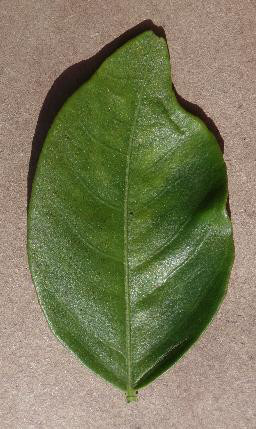

In [5]:
#Example:
PIL.Image.open('/home/ubuntu/AgriculturalDisease_trainingset/images/0a1c9371-1092-4228-b09e-a4d0647e5316___CREC_HLB 4844.JPG')

In [6]:
#Defining img_resize
#Build a function to resize different leaf images...
def img_resize(imgpath, img_size):
    
    # resize the image to the specific size
    img = PIL.Image.open(imgpath)
    if (img.width > img.height):
        scale = float(img_size) / float(img.height)
        img = np.array(cv2.resize(np.array(img), (int(img.width * scale + 1), img_size))).astype(np.float32)
    else:
        scale = float(img_size) / float(img.width)
        img = np.array(cv2.resize(np.array(img), (img_size, int(img.height * scale + 1)))).astype(np.float32)
        
    # crop the proper size and scale to [-1, 1]
    img = (img[
            (img.shape[0] - img_size) // 2:
            (img.shape[0] - img_size) // 2 + img_size,
            (img.shape[1] - img_size) // 2:
            (img.shape[1] - img_size) // 2 + img_size,
            :]-127)/128
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image after resizing


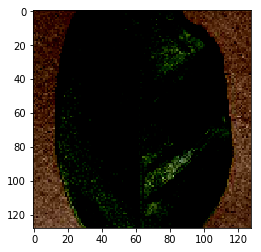

In [7]:
print("image after resizing")

imgpath ='AgriculturalDisease_trainingset/images/0a1c9371-1092-4228-b09e-a4d0647e5316___CREC_HLB 4844.JPG'
img_size = 128
Image = img_resize(imgpath, img_size)

from matplotlib import pyplot as plt
plt.imshow(Image, interpolation='nearest')
plt.show()
# Now we get the image after resizing the original image. 
# Reason for the darker of resized image (compare with the original): It should be darker! 
# Because we also changed the RBG value when we resized the original image.

In [8]:
#Importing label names
image_name_df = pd.read_excel(IMG_LBL_PATH, sheet_name='Sheet1')
image_name_df.columns = ['species', 'label_id', 'label']
#save_class = ' '
species = []
for idx in image_name_df.index:
    if (pd.isnull(image_name_df.at[idx,'species'])):
        image_name_df.at[idx,'species'] = save_class
    else:
        save_class = image_name_df.at[idx,'species']
        species.append(save_class)
imn_df = image_name_df.reset_index(drop=True)

In [9]:
imn_df.head(8)

,species,label_id,label
0,Apple,0,apple healthy
1,Apple,1,Apple_Scab general
2,Apple,2,Apple_Scab serious
3,Apple,3,Apple Frogeye Spot
4,Cedar,4,Cedar Apple Rust general
5,Cedar,5,Cedar Apple Rust serious
6,Cherry,6,Cherry healthy
7,Cherry,7,Cherry_Powdery Mildew general


In [10]:
#Importing image names
image_id_df = read_json(IMG_JSON_PATH)
image_id_df.columns = ['label_id', 'image_name']
imi_df = image_id_df.reset_index(drop=True)

image_id_df.head()

,label_id,image_name
0,1,62fd8bf4d53a1b94fbac16738406f10b.jpg
1,1,0bdec5cccbcade6b6e94087cb5509d98.jpg
2,1,8951e940341f77c8d361c1872c67b16d.jpg
3,1,7ed158da58c451f75fb790530d6f19cc.jpg
4,1,9b7399aa-1c3c-4137-ae4e-196cd23fe573___FREC_Sc...


In [11]:
#Combining labels and image names
images_df = pd.merge(imn_df, imi_df, how='inner', on='label_id')

#Random shuffle plant data
plant_df = images_df.sample(frac=1).reset_index(drop=True)
plant_df.tail()

,species,label_id,label,image_name
31713,Citrus,25,Citrus Greening June general,3e6c262a2877a3b1131bc88c84f3499f.jpg
31714,Tomato,49,Tomato_Late Blight Water Mold serious,3879647c66da1e043ee1a4512d2c083e.jpg
31715,Tomato,41,Tomato healthy,6f8da51162f3d46312d901724c195c7c.jpg
31716,Tomato,55,Tomato_Septoria Leaf Spot Fungus serious,cefa848b867a6df07c660008dea0b8cd.jpg
31717,Peach,29,Peach_Bacterial Spot serious,61d515e0909828d283b61db295728b22.jpg


In [12]:
#Defining img_resize
#Build a function to resize different leaf images...
def img_resize(imgpath, img_size):
    
    # resize the image to the specific size
    img = PIL.Image.open(imgpath)
    if (img.width > img.height):
        scale = float(img_size) / float(img.height)
        img = np.array(cv2.resize(np.array(img), (int(img.width * scale + 1), img_size))).astype(np.float32)
    else:
        scale = float(img_size) / float(img.width)
        img = np.array(cv2.resize(np.array(img), (img_size, int(img.height * scale + 1)))).astype(np.float32)
        
    # crop the proper size and scale to [-1, 1]
    img = (img[
            (img.shape[0] - img_size) // 2:
            (img.shape[0] - img_size) // 2 + img_size,
            (img.shape[1] - img_size) // 2:
            (img.shape[1] - img_size) // 2 + img_size,
            :]-127)/255
    return img

In [13]:
img_data = []
img_species = []
img_label = []
img_id = []

cnt = 0
for idx in plant_df.index:
    imgpath = IMG_JPG_PATH  + plant_df.at[idx,'image_name']
    cnt = cnt + 1
    if (cnt % 5000 == 0):
        print(str(cnt)+'th ---->', imgpath) #Add path before image name
    img_data.append(img_resize(imgpath, IMAGE_SIZE)) #get new image_datas_array
    img_species.append(plant_df.at[idx,'species']) #get species for each datas_array
    img_label.append(plant_df.at[idx,'label'])
    img_id.append(plant_df.at[idx,'label_id'])  

5000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/53611e75c6c8131f42776058e5222f4a.jpg
10000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/c556ad9e-d84f-4d18-a4c8-681acb283999___UMD_Powd.M 0038.JPG
15000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/7a6fde1700a94e642ae375dfa5121afc.jpg
20000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/5bd9f6f08c9d22a32dd831e6b8d147dd.jpg
25000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/25281e43-2651-423f-8e7e-d354185ccd28___RS_Erly.B 7809.JPG
30000th ----> /home/ubuntu/AgriculturalDisease_trainingset/images/bfbc366b-d28e-48d6-9f82-d57535e17889___RS_L.Scorch 9993.JPG


In [14]:
print(len(plant_df.species.unique())) #check
print(len(plant_df.label.unique()))

14
61


In [15]:
plant_df.label.value_counts().head(10) #61 totally

Tomato YLCV Virus serious                 2473
Citrus Greening June general              1828
Citrus Greening June serious              1799
Potato healthy                            1430
Tomato YLCV Virus general                 1414
Tomato healthy                            1208
apple healthy                             1185
Tomato_Late Blight Water Mold serious     1109
Pepper healthy                            1025
tomato powdery mildew serious              966
Name: label, dtype: int64

In [16]:
X_data = np.array(img_data)
X_data.shape

(31718, 128, 128, 3)

In [17]:
# encode labels
labelencoder = LabelEncoder()
l=labelencoder.fit_transform(img_label)
pd.DataFrame(l).head()

,0
0,19
1,22
2,56
3,23
4,12


In [18]:
# encode labels
labelencoder = LabelEncoder()
y_data_1d = labelencoder.fit_transform(img_label)
y_data = to_categorical(y_data_1d)
pd.DataFrame(y_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [19]:
# encode labels
labelencoder = LabelEncoder()
y_data_1d = labelencoder.fit_transform(img_label)
y_data = to_categorical(y_data_1d)
print(y_data.shape)
print(y_data[0:1])

(31718, 61)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [20]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED)

In [21]:
X_data

array([[[[ 0.28235295,  0.26666668,  0.25490198],
         [ 0.27450982,  0.2627451 ,  0.24705882],
         [ 0.30980393,  0.29411766,  0.2784314 ],
         ...,
         [ 0.20392157,  0.16470589,  0.16078432],
         [ 0.1254902 ,  0.08627451,  0.07843138],
         [ 0.18431373,  0.14509805,  0.13725491]],

        [[ 0.27450982,  0.25882354,  0.24705882],
         [ 0.29411766,  0.2784314 ,  0.26666668],
         [ 0.27450982,  0.25882354,  0.24705882],
         ...,
         [ 0.15686275,  0.11764706,  0.10980392],
         [ 0.11764706,  0.07843138,  0.07058824],
         [ 0.21176471,  0.17254902,  0.16470589]],

        [[ 0.27450982,  0.25490198,  0.24705882],
         [ 0.24705882,  0.23137255,  0.21960784],
         [ 0.24313726,  0.22745098,  0.21568628],
         ...,
         [ 0.16078432,  0.12156863,  0.11372549],
         [ 0.16470589,  0.1254902 ,  0.11764706],
         [ 0.19607843,  0.15686275,  0.14901961]],

        ...,

        [[ 0.16862746,  0.11764706,  0

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28546, 128, 128, 3)
(3172, 128, 128, 3)
(28546, 61)
(3172, 61)


# Convolution Neural Network

In [23]:
#Defining basic_cnn
def basic_cnn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = (X_data.shape[1], X_data.shape[2], X_data.shape[3]), 
                     filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu')) #relu: deal with vanishing gradient
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(DISEASE_CLASSES, activation = 'softmax'))  
    adam = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model  

#Defining deep_cnn (VGG)
def deep_cnn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = (X_data.shape[1], X_data.shape[2], X_data.shape[3]), 
                      filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())
    model.add(Dense(200, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(DISEASE_CLASSES, activation = 'softmax'))   
    adam = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model   

In [24]:
#Basic CNN:

model_basic = basic_cnn()

In [25]:
model_basic.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               26214500  
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 61)                1281      
Total para

In [26]:
scores = model_basic.evaluate(X_test, y_test)
print('Test accuracy: ', scores[1])

3172/3172 [==============================] - 12s 4ms/step
Test accuracy:  0.010718789407313998


In [27]:
#Deep CNN (VGG) info:
model = deep_cnn()

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_3 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 64)        0         
__________

In [29]:
'''
Why the Total params decreases: 
The function of pooling is to continuously reduce the dimensionality to 
reduce the number of parameters and computation in the network. 
This shortens the training time and controls overfitting.
'''

'\nWhy the Total params decreases: \nThe function of pooling is to continuously reduce the dimensionality to \nreduce the number of parameters and computation in the network. \nThis shortens the training time and controls overfitting.\n'

## Model Implementations

In [35]:
# For the CNN basic model with 8 epochs
%%time 
history = model_basic.fit(X_train, y_train, 
                    batch_size = BATCH_SIZE, 
                    validation_split = 0.10, 
                    epochs = EPOCHS, 
                    verbose = 2)

Train on 25691 samples, validate on 2855 samples
Epoch 1/8
 - 89s - loss: 2.4712 - acc: 0.3444 - val_loss: 1.5127 - val_acc: 0.5643
Epoch 2/8
 - 88s - loss: 1.1571 - acc: 0.6342 - val_loss: 1.0874 - val_acc: 0.6536
Epoch 3/8
 - 88s - loss: 0.7565 - acc: 0.7398 - val_loss: 1.0823 - val_acc: 0.6697
Epoch 4/8
 - 88s - loss: 0.5168 - acc: 0.8166 - val_loss: 1.1879 - val_acc: 0.6620
Epoch 5/8
 - 88s - loss: 0.3701 - acc: 0.8668 - val_loss: 1.3558 - val_acc: 0.6676
Epoch 6/8
 - 88s - loss: 0.2948 - acc: 0.8941 - val_loss: 1.5374 - val_acc: 0.6508
Epoch 7/8
 - 88s - loss: 0.2321 - acc: 0.9176 - val_loss: 1.7031 - val_acc: 0.6504
Epoch 8/8
 - 88s - loss: 0.2046 - acc: 0.9270 - val_loss: 1.7817 - val_acc: 0.6406
CPU times: user 7min 52s, sys: 2min 49s, total: 10min 41s
Wall time: 11min 45s


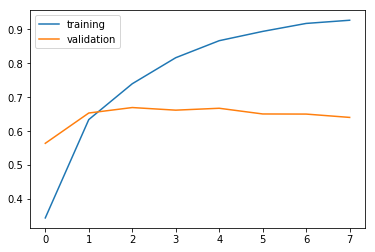

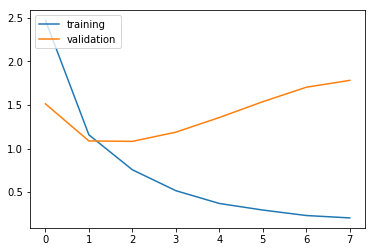

In [36]:
#graph of Train and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

#graph of Train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [51]:
#After Data Augmentations for basic CNN model
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [52]:
BS= 16

In [53]:
history = model_basic.fit_generator(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/8
1784/1784 [==============================] - 103s 58ms/step - loss: 1.4134 - acc: 0.5916 - val_loss: 1.1517 - val_acc: 0.6633
Epoch 2/8
1784/1784 [==============================] - 102s 57ms/step - loss: 1.1168 - acc: 0.6465 - val_loss: 1.1639 - val_acc: 0.6671
Epoch 3/8
1784/1784 [==============================] - 102s 57ms/step - loss: 1.0175 - acc: 0.6682 - val_loss: 1.1039 - val_acc: 0.6756
Epoch 4/8
1784/1784 [==============================] - 102s 57ms/step - loss: 0.9685 - acc: 0.6820 - val_loss: 1.3318 - val_acc: 0.6526
Epoch 5/8
1784/1784 [==============================] - 102s 57ms/step - loss: 0.9165 - acc: 0.6928 - val_loss: 1.0478 - val_acc: 0.7002
Epoch 6/8
1784/1784 [==============================] - 102s 57ms/step - loss: 0.8744 - acc: 0.7060 - val_loss: 1.0922 - val_acc: 0.6828
Epoch 7/8
1784/1784 [==============================] - 102s 57ms/step - loss: 0.8524 - acc: 0.7119 - val_loss: 1.1346 - val_acc: 0.6737
Epoch 8/8
1784/1784 [===========================

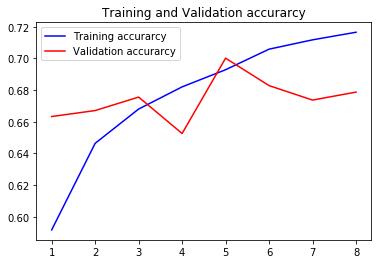

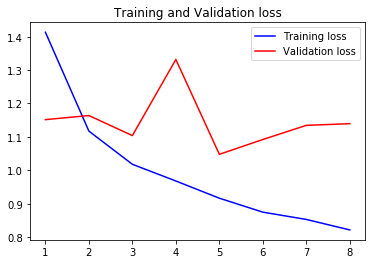

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [56]:
# For the CNN(VGG) deep model
%%time 
history = model.fit(X_train, y_train, 
                    batch_size = BATCH_SIZE, 
                    validation_split = 0.20, #change split ratio to 0.2
                    epochs = 5, 
                    verbose = 2)

Train on 22836 samples, validate on 5710 samples
Epoch 1/5
 - 78s - loss: 0.0849 - acc: 0.9761 - val_loss: 0.6984 - val_acc: 0.8660
Epoch 2/5
 - 77s - loss: 0.0702 - acc: 0.9775 - val_loss: 0.7740 - val_acc: 0.8695
Epoch 3/5
 - 77s - loss: 0.0907 - acc: 0.9726 - val_loss: 0.7465 - val_acc: 0.8583
Epoch 4/5
 - 77s - loss: 0.0798 - acc: 0.9769 - val_loss: 0.7342 - val_acc: 0.8680
Epoch 5/5
 - 77s - loss: 0.0854 - acc: 0.9760 - val_loss: 0.7148 - val_acc: 0.8709
CPU times: user 3min 53s, sys: 1min 16s, total: 5min 9s
Wall time: 6min 26s


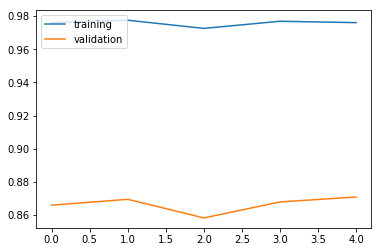

In [57]:
#graph of Train and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

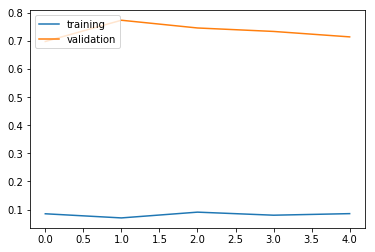

In [58]:
#graph of Train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [59]:
scores = model.evaluate(X_test, y_test)
print('Test accuracy: ', scores[1])

3172/3172 [==============================] - 3s 1ms/step
Test accuracy:  0.7786885245901639


In [44]:
# data augmentation for CNN(VGG) deep model
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [45]:
BS=16

history_new = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/8
1784/1784 [==============================] - 105s 59ms/step - loss: 2.6164 - acc: 0.2977 - val_loss: 1.4049 - val_acc: 0.5599
Epoch 2/8
1784/1784 [==============================] - 103s 58ms/step - loss: 1.3893 - acc: 0.5658 - val_loss: 0.9686 - val_acc: 0.6728
Epoch 3/8
1784/1784 [==============================] - 104s 58ms/step - loss: 1.0586 - acc: 0.6456 - val_loss: 0.8119 - val_acc: 0.7251
Epoch 4/8
1784/1784 [==============================] - 103s 58ms/step - loss: 0.9047 - acc: 0.6903 - val_loss: 0.7849 - val_acc: 0.7191
Epoch 5/8
1784/1784 [==============================] - 104s 58ms/step - loss: 0.8062 - acc: 0.7149 - val_loss: 0.7002 - val_acc: 0.7503
Epoch 6/8
1784/1784 [==============================] - 104s 59ms/step - loss: 0.7287 - acc: 0.7399 - val_loss: 0.6889 - val_acc: 0.7547
Epoch 7/8
1784/1784 [==============================] - 104s 58ms/step - loss: 0.6838 - acc: 0.7539 - val_loss: 0.5632 - val_acc: 0.7998
Epoch 8/8
1784/1784 [===========================

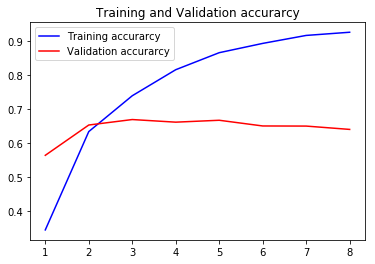

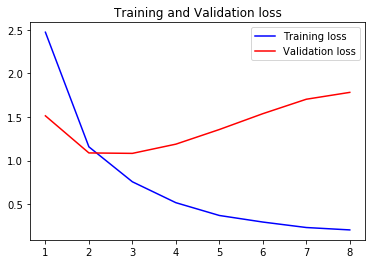

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Test dataset prediction output

In [37]:
model_json = model_basic.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("my_model.h5")
print("Saved my model to disk")


Saved my model to disk


In [38]:
import os
IMG_TST_PATH = 'Test_images/'
tst_files = []
for root, dirs, files in os.walk(IMG_TST_PATH):
    for file in files:
        if file.endswith('.jpg'):
            f = file.find('.')
            fn = file[0:f]
            tst_files.append(file[0:f])
tst_files = [int(i) for i in tst_files]
tst_files.sort() 


In [39]:
tst_img_data = []
tidx = len(tst_files)
for i in range(tidx):
#    print(tst_files[i])
    j = i + 1
    imgpath = IMG_TST_PATH + str(j) + '.jpg'
    print(imgpath)
    imag = img_resize(imgpath, IMAGE_SIZE)
    tst_img_data.append(imag)


Test_images/1.jpg
Test_images/2.jpg
Test_images/3.jpg
Test_images/4.jpg
Test_images/5.jpg
Test_images/6.jpg
Test_images/7.jpg
Test_images/8.jpg
Test_images/9.jpg
Test_images/10.jpg
Test_images/11.jpg
Test_images/12.jpg
Test_images/13.jpg
Test_images/14.jpg
Test_images/15.jpg
Test_images/16.jpg
Test_images/17.jpg
Test_images/18.jpg
Test_images/19.jpg
Test_images/20.jpg
Test_images/21.jpg
Test_images/22.jpg
Test_images/23.jpg
Test_images/24.jpg
Test_images/25.jpg
Test_images/26.jpg
Test_images/27.jpg
Test_images/28.jpg
Test_images/29.jpg
Test_images/30.jpg
Test_images/31.jpg
Test_images/32.jpg
Test_images/33.jpg
Test_images/34.jpg
Test_images/35.jpg
Test_images/36.jpg
Test_images/37.jpg
Test_images/38.jpg
Test_images/39.jpg
Test_images/40.jpg
Test_images/41.jpg
Test_images/42.jpg
Test_images/43.jpg
Test_images/44.jpg
Test_images/45.jpg
Test_images/46.jpg
Test_images/47.jpg
Test_images/48.jpg
Test_images/49.jpg
Test_images/50.jpg
Test_images/51.jpg
Test_images/52.jpg
Test_images/53.jpg
Te

Test_images/465.jpg
Test_images/466.jpg
Test_images/467.jpg
Test_images/468.jpg
Test_images/469.jpg
Test_images/470.jpg
Test_images/471.jpg
Test_images/472.jpg
Test_images/473.jpg
Test_images/474.jpg
Test_images/475.jpg
Test_images/476.jpg
Test_images/477.jpg
Test_images/478.jpg
Test_images/479.jpg
Test_images/480.jpg
Test_images/481.jpg
Test_images/482.jpg
Test_images/483.jpg
Test_images/484.jpg
Test_images/485.jpg
Test_images/486.jpg
Test_images/487.jpg
Test_images/488.jpg
Test_images/489.jpg
Test_images/490.jpg
Test_images/491.jpg
Test_images/492.jpg
Test_images/493.jpg
Test_images/494.jpg
Test_images/495.jpg
Test_images/496.jpg
Test_images/497.jpg
Test_images/498.jpg
Test_images/499.jpg
Test_images/500.jpg
Test_images/501.jpg
Test_images/502.jpg
Test_images/503.jpg
Test_images/504.jpg
Test_images/505.jpg
Test_images/506.jpg
Test_images/507.jpg
Test_images/508.jpg
Test_images/509.jpg
Test_images/510.jpg
Test_images/511.jpg
Test_images/512.jpg
Test_images/513.jpg
Test_images/514.jpg


Test_images/878.jpg
Test_images/879.jpg
Test_images/880.jpg
Test_images/881.jpg
Test_images/882.jpg
Test_images/883.jpg
Test_images/884.jpg
Test_images/885.jpg
Test_images/886.jpg
Test_images/887.jpg
Test_images/888.jpg
Test_images/889.jpg
Test_images/890.jpg
Test_images/891.jpg
Test_images/892.jpg
Test_images/893.jpg
Test_images/894.jpg
Test_images/895.jpg
Test_images/896.jpg
Test_images/897.jpg
Test_images/898.jpg
Test_images/899.jpg
Test_images/900.jpg
Test_images/901.jpg
Test_images/902.jpg
Test_images/903.jpg
Test_images/904.jpg
Test_images/905.jpg
Test_images/906.jpg
Test_images/907.jpg
Test_images/908.jpg
Test_images/909.jpg
Test_images/910.jpg
Test_images/911.jpg
Test_images/912.jpg
Test_images/913.jpg
Test_images/914.jpg
Test_images/915.jpg
Test_images/916.jpg
Test_images/917.jpg
Test_images/918.jpg
Test_images/919.jpg
Test_images/920.jpg
Test_images/921.jpg
Test_images/922.jpg
Test_images/923.jpg
Test_images/924.jpg
Test_images/925.jpg
Test_images/926.jpg
Test_images/927.jpg


Test_images/1279.jpg
Test_images/1280.jpg
Test_images/1281.jpg
Test_images/1282.jpg
Test_images/1283.jpg
Test_images/1284.jpg
Test_images/1285.jpg
Test_images/1286.jpg
Test_images/1287.jpg
Test_images/1288.jpg
Test_images/1289.jpg
Test_images/1290.jpg
Test_images/1291.jpg
Test_images/1292.jpg
Test_images/1293.jpg
Test_images/1294.jpg
Test_images/1295.jpg
Test_images/1296.jpg
Test_images/1297.jpg
Test_images/1298.jpg
Test_images/1299.jpg
Test_images/1300.jpg
Test_images/1301.jpg
Test_images/1302.jpg
Test_images/1303.jpg
Test_images/1304.jpg
Test_images/1305.jpg
Test_images/1306.jpg
Test_images/1307.jpg
Test_images/1308.jpg
Test_images/1309.jpg
Test_images/1310.jpg
Test_images/1311.jpg
Test_images/1312.jpg
Test_images/1313.jpg
Test_images/1314.jpg
Test_images/1315.jpg
Test_images/1316.jpg
Test_images/1317.jpg
Test_images/1318.jpg
Test_images/1319.jpg
Test_images/1320.jpg
Test_images/1321.jpg
Test_images/1322.jpg
Test_images/1323.jpg
Test_images/1324.jpg
Test_images/1325.jpg
Test_images/1

Test_images/1744.jpg
Test_images/1745.jpg
Test_images/1746.jpg
Test_images/1747.jpg
Test_images/1748.jpg
Test_images/1749.jpg
Test_images/1750.jpg
Test_images/1751.jpg
Test_images/1752.jpg
Test_images/1753.jpg
Test_images/1754.jpg
Test_images/1755.jpg
Test_images/1756.jpg
Test_images/1757.jpg
Test_images/1758.jpg
Test_images/1759.jpg
Test_images/1760.jpg
Test_images/1761.jpg
Test_images/1762.jpg
Test_images/1763.jpg
Test_images/1764.jpg
Test_images/1765.jpg
Test_images/1766.jpg
Test_images/1767.jpg
Test_images/1768.jpg
Test_images/1769.jpg
Test_images/1770.jpg
Test_images/1771.jpg
Test_images/1772.jpg
Test_images/1773.jpg
Test_images/1774.jpg
Test_images/1775.jpg
Test_images/1776.jpg
Test_images/1777.jpg
Test_images/1778.jpg
Test_images/1779.jpg
Test_images/1780.jpg
Test_images/1781.jpg
Test_images/1782.jpg
Test_images/1783.jpg
Test_images/1784.jpg
Test_images/1785.jpg
Test_images/1786.jpg
Test_images/1787.jpg
Test_images/1788.jpg
Test_images/1789.jpg
Test_images/1790.jpg
Test_images/1

Test_images/2203.jpg
Test_images/2204.jpg
Test_images/2205.jpg
Test_images/2206.jpg
Test_images/2207.jpg
Test_images/2208.jpg
Test_images/2209.jpg
Test_images/2210.jpg
Test_images/2211.jpg
Test_images/2212.jpg
Test_images/2213.jpg
Test_images/2214.jpg
Test_images/2215.jpg
Test_images/2216.jpg
Test_images/2217.jpg
Test_images/2218.jpg
Test_images/2219.jpg
Test_images/2220.jpg
Test_images/2221.jpg
Test_images/2222.jpg
Test_images/2223.jpg
Test_images/2224.jpg
Test_images/2225.jpg
Test_images/2226.jpg
Test_images/2227.jpg
Test_images/2228.jpg
Test_images/2229.jpg
Test_images/2230.jpg
Test_images/2231.jpg
Test_images/2232.jpg
Test_images/2233.jpg
Test_images/2234.jpg
Test_images/2235.jpg
Test_images/2236.jpg
Test_images/2237.jpg
Test_images/2238.jpg
Test_images/2239.jpg
Test_images/2240.jpg
Test_images/2241.jpg
Test_images/2242.jpg
Test_images/2243.jpg
Test_images/2244.jpg
Test_images/2245.jpg
Test_images/2246.jpg
Test_images/2247.jpg
Test_images/2248.jpg
Test_images/2249.jpg
Test_images/2

Test_images/2615.jpg
Test_images/2616.jpg
Test_images/2617.jpg
Test_images/2618.jpg
Test_images/2619.jpg
Test_images/2620.jpg
Test_images/2621.jpg
Test_images/2622.jpg
Test_images/2623.jpg
Test_images/2624.jpg
Test_images/2625.jpg
Test_images/2626.jpg
Test_images/2627.jpg
Test_images/2628.jpg
Test_images/2629.jpg
Test_images/2630.jpg
Test_images/2631.jpg
Test_images/2632.jpg
Test_images/2633.jpg
Test_images/2634.jpg
Test_images/2635.jpg
Test_images/2636.jpg
Test_images/2637.jpg
Test_images/2638.jpg
Test_images/2639.jpg
Test_images/2640.jpg
Test_images/2641.jpg
Test_images/2642.jpg
Test_images/2643.jpg
Test_images/2644.jpg
Test_images/2645.jpg
Test_images/2646.jpg
Test_images/2647.jpg
Test_images/2648.jpg
Test_images/2649.jpg
Test_images/2650.jpg
Test_images/2651.jpg
Test_images/2652.jpg
Test_images/2653.jpg
Test_images/2654.jpg
Test_images/2655.jpg
Test_images/2656.jpg
Test_images/2657.jpg
Test_images/2658.jpg
Test_images/2659.jpg
Test_images/2660.jpg
Test_images/2661.jpg
Test_images/2

Test_images/3006.jpg
Test_images/3007.jpg
Test_images/3008.jpg
Test_images/3009.jpg
Test_images/3010.jpg
Test_images/3011.jpg
Test_images/3012.jpg
Test_images/3013.jpg
Test_images/3014.jpg
Test_images/3015.jpg
Test_images/3016.jpg
Test_images/3017.jpg
Test_images/3018.jpg
Test_images/3019.jpg
Test_images/3020.jpg
Test_images/3021.jpg
Test_images/3022.jpg
Test_images/3023.jpg
Test_images/3024.jpg
Test_images/3025.jpg
Test_images/3026.jpg
Test_images/3027.jpg
Test_images/3028.jpg
Test_images/3029.jpg
Test_images/3030.jpg
Test_images/3031.jpg
Test_images/3032.jpg
Test_images/3033.jpg
Test_images/3034.jpg
Test_images/3035.jpg
Test_images/3036.jpg
Test_images/3037.jpg
Test_images/3038.jpg
Test_images/3039.jpg
Test_images/3040.jpg
Test_images/3041.jpg
Test_images/3042.jpg
Test_images/3043.jpg
Test_images/3044.jpg
Test_images/3045.jpg
Test_images/3046.jpg
Test_images/3047.jpg
Test_images/3048.jpg
Test_images/3049.jpg
Test_images/3050.jpg
Test_images/3051.jpg
Test_images/3052.jpg
Test_images/3

Test_images/3437.jpg
Test_images/3438.jpg
Test_images/3439.jpg
Test_images/3440.jpg
Test_images/3441.jpg
Test_images/3442.jpg
Test_images/3443.jpg
Test_images/3444.jpg
Test_images/3445.jpg
Test_images/3446.jpg
Test_images/3447.jpg
Test_images/3448.jpg
Test_images/3449.jpg
Test_images/3450.jpg
Test_images/3451.jpg
Test_images/3452.jpg
Test_images/3453.jpg
Test_images/3454.jpg
Test_images/3455.jpg
Test_images/3456.jpg
Test_images/3457.jpg
Test_images/3458.jpg
Test_images/3459.jpg
Test_images/3460.jpg
Test_images/3461.jpg
Test_images/3462.jpg
Test_images/3463.jpg
Test_images/3464.jpg
Test_images/3465.jpg
Test_images/3466.jpg
Test_images/3467.jpg
Test_images/3468.jpg
Test_images/3469.jpg
Test_images/3470.jpg
Test_images/3471.jpg
Test_images/3472.jpg
Test_images/3473.jpg
Test_images/3474.jpg
Test_images/3475.jpg
Test_images/3476.jpg
Test_images/3477.jpg
Test_images/3478.jpg
Test_images/3479.jpg
Test_images/3480.jpg
Test_images/3481.jpg
Test_images/3482.jpg
Test_images/3483.jpg
Test_images/3

Test_images/3829.jpg
Test_images/3830.jpg
Test_images/3831.jpg
Test_images/3832.jpg
Test_images/3833.jpg
Test_images/3834.jpg
Test_images/3835.jpg
Test_images/3836.jpg
Test_images/3837.jpg
Test_images/3838.jpg
Test_images/3839.jpg
Test_images/3840.jpg
Test_images/3841.jpg
Test_images/3842.jpg
Test_images/3843.jpg
Test_images/3844.jpg
Test_images/3845.jpg
Test_images/3846.jpg
Test_images/3847.jpg
Test_images/3848.jpg
Test_images/3849.jpg
Test_images/3850.jpg
Test_images/3851.jpg
Test_images/3852.jpg
Test_images/3853.jpg
Test_images/3854.jpg
Test_images/3855.jpg
Test_images/3856.jpg
Test_images/3857.jpg
Test_images/3858.jpg
Test_images/3859.jpg
Test_images/3860.jpg
Test_images/3861.jpg
Test_images/3862.jpg
Test_images/3863.jpg
Test_images/3864.jpg
Test_images/3865.jpg
Test_images/3866.jpg
Test_images/3867.jpg
Test_images/3868.jpg
Test_images/3869.jpg
Test_images/3870.jpg
Test_images/3871.jpg
Test_images/3872.jpg
Test_images/3873.jpg
Test_images/3874.jpg
Test_images/3875.jpg
Test_images/3

Test_images/4228.jpg
Test_images/4229.jpg
Test_images/4230.jpg
Test_images/4231.jpg
Test_images/4232.jpg
Test_images/4233.jpg
Test_images/4234.jpg
Test_images/4235.jpg
Test_images/4236.jpg
Test_images/4237.jpg
Test_images/4238.jpg
Test_images/4239.jpg
Test_images/4240.jpg
Test_images/4241.jpg
Test_images/4242.jpg
Test_images/4243.jpg
Test_images/4244.jpg
Test_images/4245.jpg
Test_images/4246.jpg
Test_images/4247.jpg
Test_images/4248.jpg
Test_images/4249.jpg
Test_images/4250.jpg
Test_images/4251.jpg
Test_images/4252.jpg
Test_images/4253.jpg
Test_images/4254.jpg
Test_images/4255.jpg
Test_images/4256.jpg
Test_images/4257.jpg
Test_images/4258.jpg
Test_images/4259.jpg
Test_images/4260.jpg
Test_images/4261.jpg
Test_images/4262.jpg
Test_images/4263.jpg
Test_images/4264.jpg
Test_images/4265.jpg
Test_images/4266.jpg
Test_images/4267.jpg
Test_images/4268.jpg
Test_images/4269.jpg
Test_images/4270.jpg
Test_images/4271.jpg
Test_images/4272.jpg
Test_images/4273.jpg
Test_images/4274.jpg
Test_images/4

In [40]:
from keras.models import model_from_json
json_file = open('my_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights('my_model.h5')
# print('Loaded model from disk')

In [41]:
#from keras.models import load_model
adam = optimizers.Adam(lr = LEARNING_RATE)
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


In [42]:
test_data = np.array(tst_img_data)
test_data = test_data.astype('float32')
test_data.shape
pred_disease_classes = []

for i in range(len(tst_files)):
    if (i % 500 == 0):
        print(str(i) + '.jpg')
    test_img = np.reshape(tst_img_data[i],[1,128,128,3])
    test_class = loaded_model.predict_classes(test_img)
    pred_disease_classes.append(test_class[0])


0.jpg
500.jpg
1000.jpg
1500.jpg
2000.jpg
2500.jpg
3000.jpg
3500.jpg
4000.jpg
4500.jpg


In [43]:
import csv
csvfile = 'Group9_predictions.csv'
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in pred_disease_classes:
        writer.writerow([val])
